In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal import welch, find_peaks

## Load Files

In [119]:
color_map = {
    0: "red",
    1: "green"
}

In [120]:
# DESK
data_desk_classroom = np.load("data_desk_classroom_20251120_170119.npy")
print("data_desk_classroom shape:", data_desk_classroom.shape)

data_desk_davide_relax = np.load("data_desk_davide_relax_20251124_181402.npy")
print("data_desk_davide_relax shape:", data_desk_davide_relax.shape)

data_desk_davide_lettura = np.load("data_desk_davide_lettura_20251124_182213.npy")
print("data_desk_davide_lettura shape:", data_desk_davide_lettura.shape)

data_hand_arr = np.load("data_hand_20251120_165216.npy")
print("Hand Array shape:", data_hand_arr.shape)

data_hand_davide_lettura = np.load("data_hand_davide_lettura_20251124_184702.npy")
print("Hand Array shape:", data_hand_davide_lettura.shape)

data_desk_classroom shape: (350, 65, 65, 2)
data_desk_davide_relax shape: (350, 65, 65, 2)
data_desk_davide_lettura shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)


## Function Definitions

In [121]:
def plot_pixel_change_matrix(data):
    """
    Plot ROI_H x ROI_W heatmaps (one per color channel) where
    darker pixels indicate larger temporal change over frames.

    data: numpy array of shape (num_frames, ROI_H, ROI_W, colors)
    """

    num_frames, ROI_H, ROI_W, colors = data.shape

    # Compute per-pixel temporal variation
    # Here: standard deviation across frames for each pixel & color
    change_map = np.std(data, axis=0)   # shape → (ROI_H, ROI_W, colors)

    # Normalize each color channel independently (0 = highest change → dark)
    norm_change = np.zeros_like(change_map)
    for c in range(colors):
        ch = change_map[:, :, c]
        ch_min, ch_max = ch.min(), ch.max()
        norm_change[:, :, c] = (ch - ch_min) / (ch_max - ch_min + 1e-9)

    # Plot each channel
    fig, axs = plt.subplots(1, colors, figsize=(5 * colors, 5))
    if colors == 1:
        axs = [axs]

    for c in range(colors):
        axs[c].imshow(1 - norm_change[:, :, c], cmap='grey')
        axs[c].set_title(f"Color channel {color_map[c]}")
        axs[c].axis("off")

    plt.tight_layout()
    plt.show()

In [122]:
def plot_frequency_spectrum(arr, x=32, y=32, channel=0, fs=2.5):
    # Extract the time-series for this pixel
    pixel_ts = arr[:, y, x, channel]

    # Compute Power Spectral Density
    freqs, psd = welch(pixel_ts, fs=fs, nperseg=256)

    # --- Detect peaks ---
    # height: ignore tiny noise peaks by setting a minimum threshold
    # distance: minimum separation between peaks in samples
    peaks, properties = find_peaks(psd, height=np.max(psd)*0.1, distance=3)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, psd, label="PSD")
    plt.scatter(freqs[peaks], psd[peaks], color='red', s=50, label="Peaks")

    # Add labels for each detected peak
    for idx in peaks:
        freq_val = freqs[idx]
        psd_val = psd[idx]
        plt.annotate(f"{freq_val:.2f} Hz",
                     xy=(freq_val, psd_val),
                     xytext=(freq_val, psd_val * 1.1),
                     arrowprops=dict(arrowstyle="->", lw=1))

    plt.title(f"Frequency Spectrum — Pixel ({y},{x}), Channel {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [123]:
def plot_frequency_spectrum_multichannel(arr, x=32, y=32, fs=2.5):
    """
    Plot the frequency spectrum for all channels at pixel (y, x)
    on the same graph, each in a different color.
    """

    num_frames, ROI_H, ROI_W, num_channels = arr.shape

    plt.figure(figsize=(12, 6))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for ch in range(num_channels):
        pixel_ts = arr[:, y, x, ch]

        # PSD
        freqs, psd = welch(pixel_ts, fs=fs, nperseg=min(256, len(pixel_ts)))

        # Peak detection
        peaks, properties = find_peaks(psd, height=np.max(psd)*0.1, distance=3)

        # col = color_cycle[ch % len(color_cycle)]
        col = color_map[ch]
        label = f"Channel {color_map[ch]}"

        # Plot PSD
        plt.plot(freqs, psd, label=label, color=col)

        # Plot peaks
        plt.scatter(freqs[peaks], psd[peaks], color=col, s=40)

        # Annotate peaks
        for idx in peaks:
            freq_val = freqs[idx]
            psd_val = psd[idx]
            plt.annotate(f"{freq_val:.2f} Hz",
                         xy=(freq_val, psd_val),
                         xytext=(freq_val, psd_val * 1.08),
                         color=col,
                         fontsize=8,
                         arrowprops=dict(arrowstyle="->", lw=0.7, color=col))

    plt.title(f"Frequency Spectrum — Pixel ({y},{x}) for all channels")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [124]:
def plot_aggregated_psd_by_channel(arr, fs=2.5, red_ch=0, green_ch=1):
    """
    Compute and plot aggregated PSD separately for red and green channels.
    Each channel’s PSD is summed over all pixels.

    arr: shape (num_frames, H, W, num_channels)
    red_ch: index of red channel
    green_ch: index of green channel
    """

    num_frames, H, W, C = arr.shape

    freqs = None
    agg_red = None
    agg_green = None

    # --- Compute PSD for each pixel for red and green channels ---
    for y in range(H):
        for x in range(W):

            # ---- Red channel ----
            ts_r = arr[:, y, x, red_ch]
            f, p_r = welch(ts_r, fs=fs, nperseg=min(256, len(ts_r)))

            if freqs is None:
                freqs = f
                agg_red = np.zeros_like(p_r)
                agg_green = np.zeros_like(p_r)

            agg_red += p_r

            # ---- Green channel ----
            ts_g = arr[:, y, x, green_ch]
            _, p_g = welch(ts_g, fs=fs, nperseg=min(256, len(ts_g)))
            agg_green += p_g

    # --- Peak detection ---
    peaks_r, _ = find_peaks(agg_red, height=np.max(agg_red) * 0.05)
    peaks_g, _ = find_peaks(agg_green, height=np.max(agg_green) * 0.05)

    # --- Plot ---
    plt.figure(figsize=(12, 6))

    # Red PSD
    plt.plot(freqs, agg_red, color="red", label="Red Aggregated PSD", lw=2)
    plt.scatter(freqs[peaks_r], agg_red[peaks_r], color="red", s=30)

    # Green PSD
    plt.plot(freqs, agg_green, color="green", label="Green Aggregated PSD", lw=2)
    plt.scatter(freqs[peaks_g], agg_green[peaks_g], color="green", s=30)

    # Annotate peaks
    for idx in peaks_r:
        plt.annotate(f"{freqs[idx]:.2f} Hz",
                     xy=(freqs[idx], agg_red[idx]),
                     xytext=(freqs[idx], agg_red[idx] * 1.05),
                     color="red",
                     fontsize=8)

    for idx in peaks_g:
        plt.annotate(f"{freqs[idx]:.2f} Hz",
                     xy=(freqs[idx], agg_green[idx]),
                     xytext=(freqs[idx], agg_green[idx] * 1.05),
                     color="green",
                     fontsize=8)

    plt.title("Aggregated PSD — Red vs Green Channels")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Summed PSD")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # return freqs, agg_red, agg_green

## Desk in class

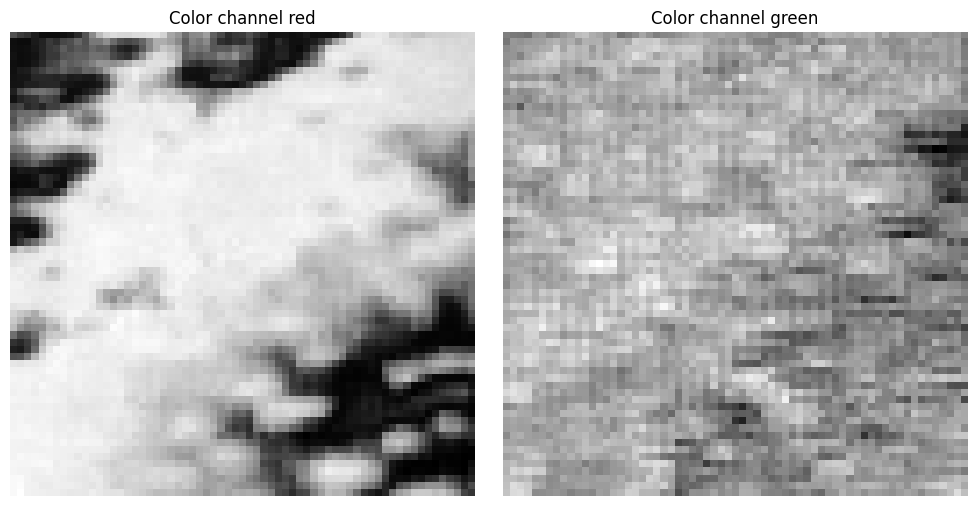

In [125]:
plot_pixel_change_matrix(data=data_desk_classroom)

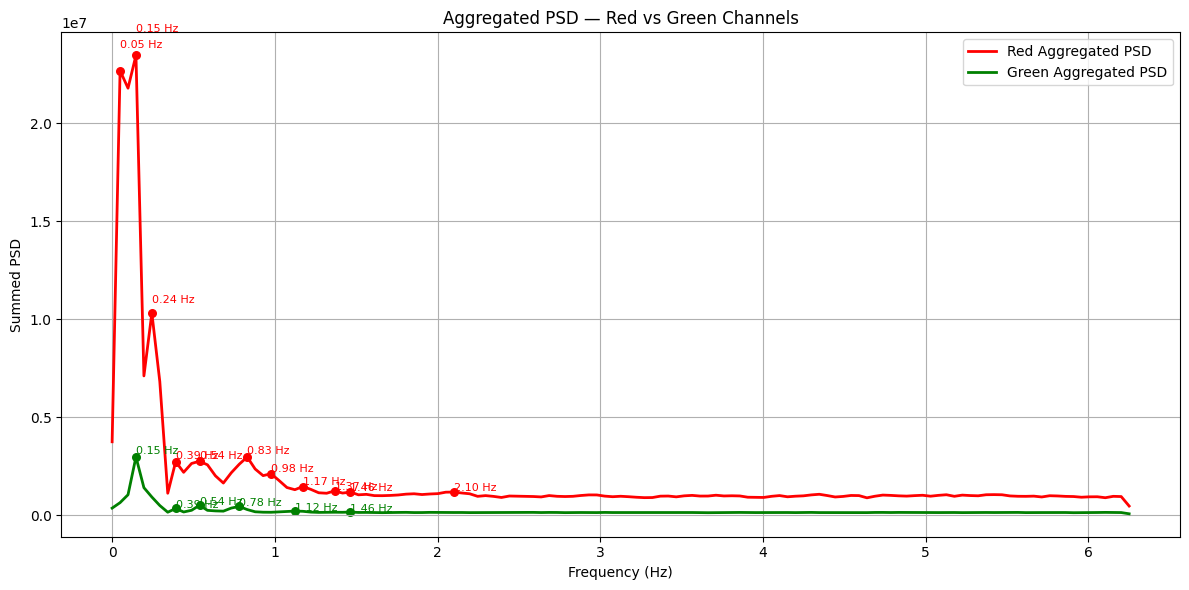

In [126]:
plot_aggregated_psd_by_channel(arr=data_desk_classroom, fs=12.5)

## Desk at Davide's Home with 'Relax' color

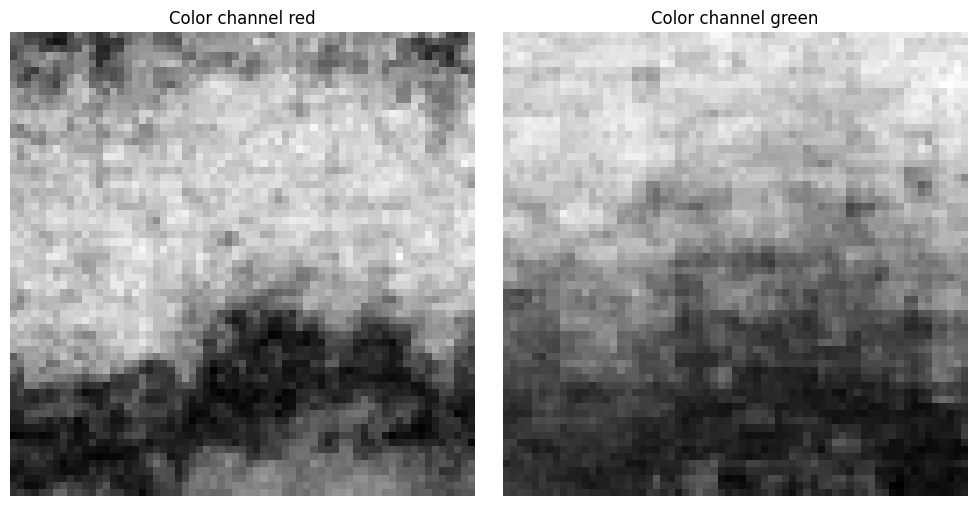

In [127]:
plot_pixel_change_matrix(data=data_desk_davide_relax)

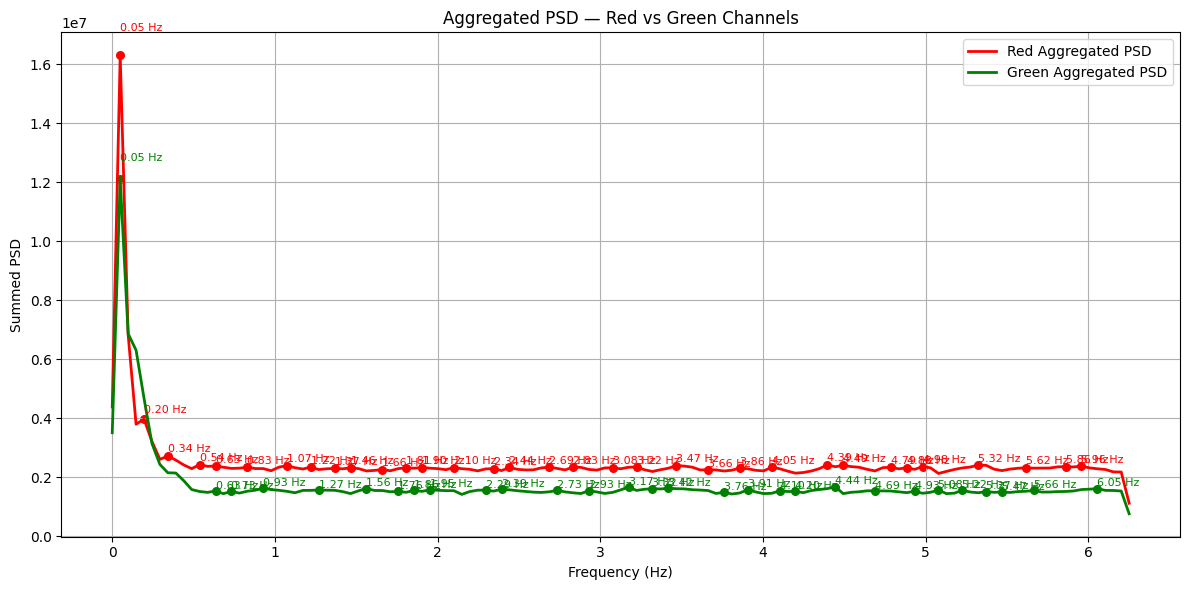

In [128]:
plot_aggregated_psd_by_channel(arr=data_desk_davide_relax, fs=12.5)

## Desk at Davide's Home with 'Lettura' color

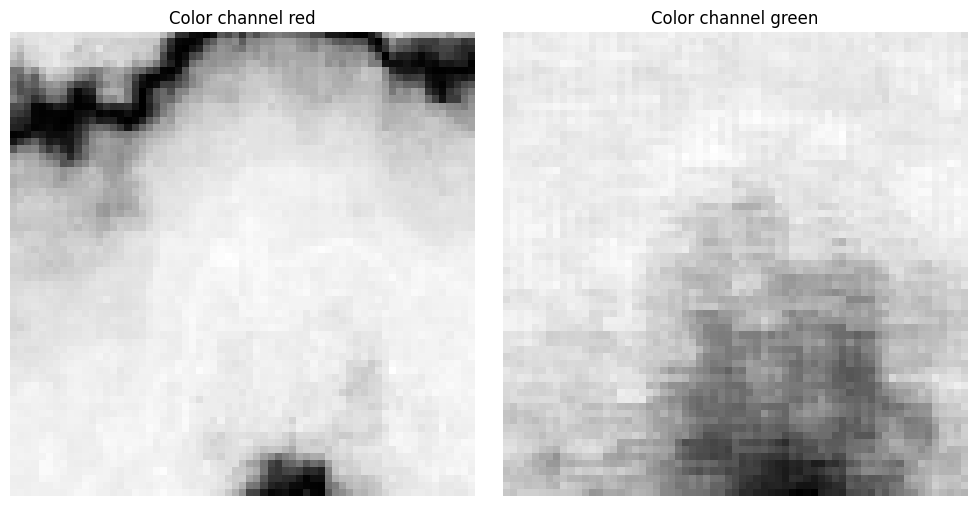

In [129]:
plot_pixel_change_matrix(data=data_desk_davide_lettura)

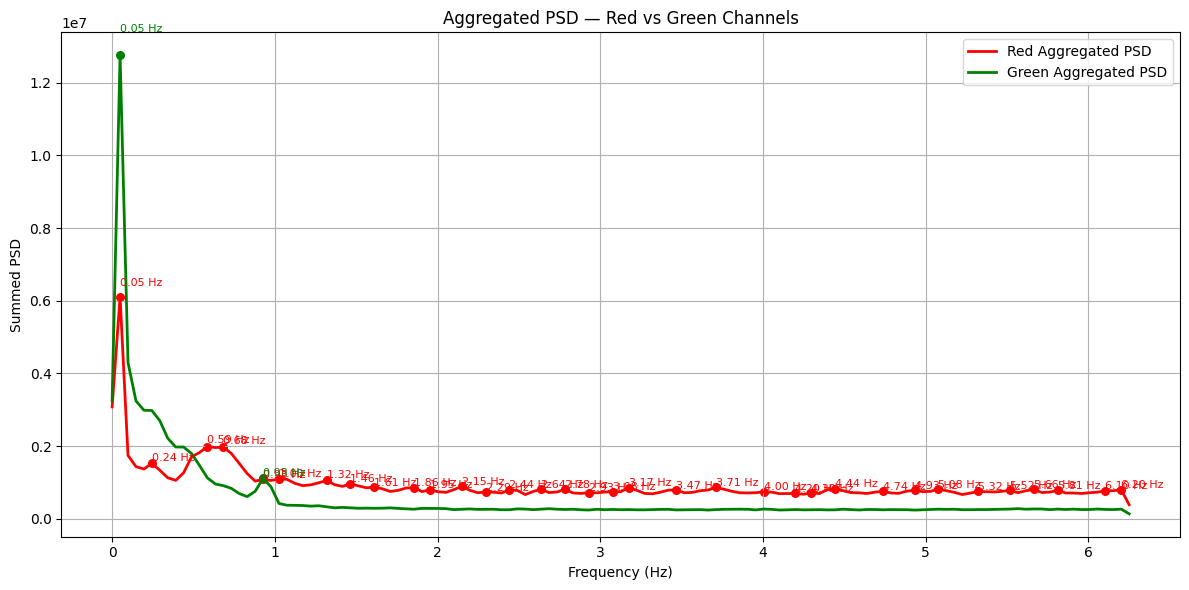

In [130]:
plot_aggregated_psd_by_channel(arr=data_desk_davide_lettura, fs=12.5)

## Hand in classroom

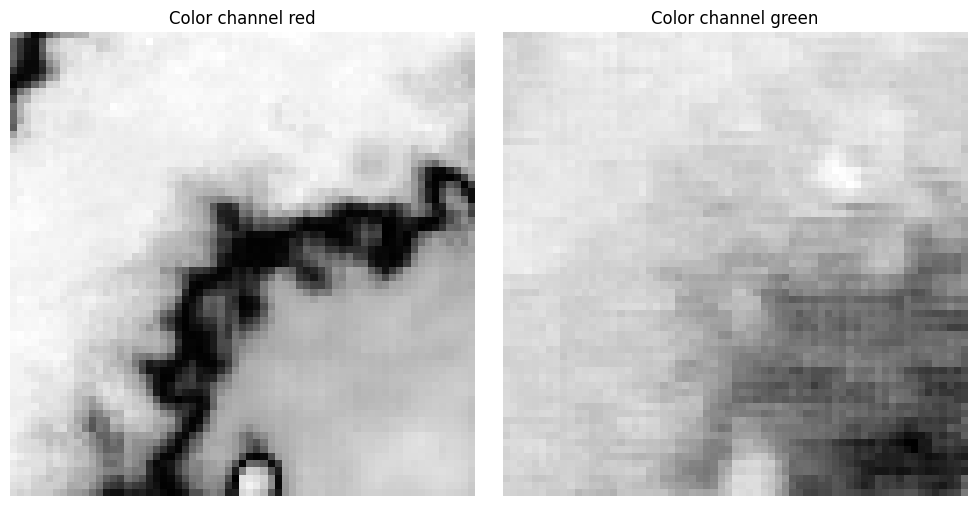

In [131]:
plot_pixel_change_matrix(data=data_hand_arr)

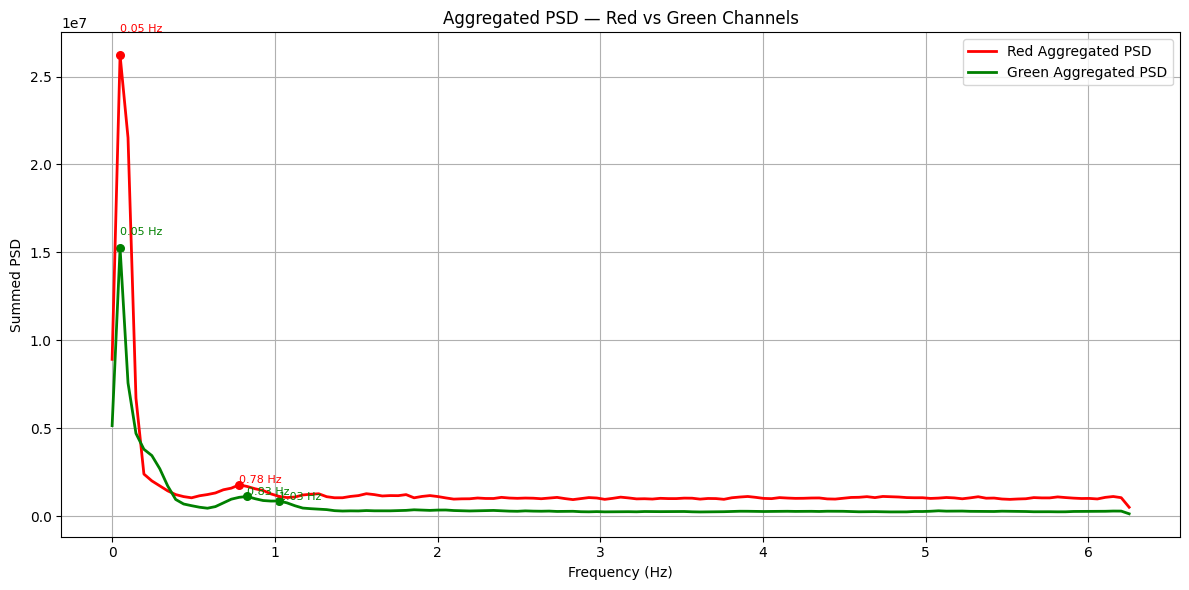

In [132]:
plot_aggregated_psd_by_channel(arr=data_hand_arr, fs=12.5)

## Davide's Hand @ Home with 'Lettura' color

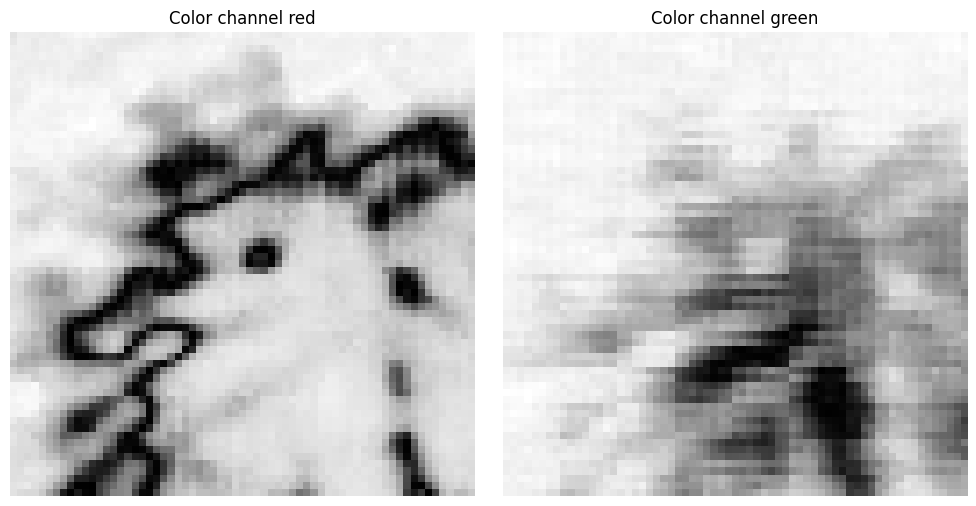

In [133]:
plot_pixel_change_matrix(data=data_hand_davide_lettura)

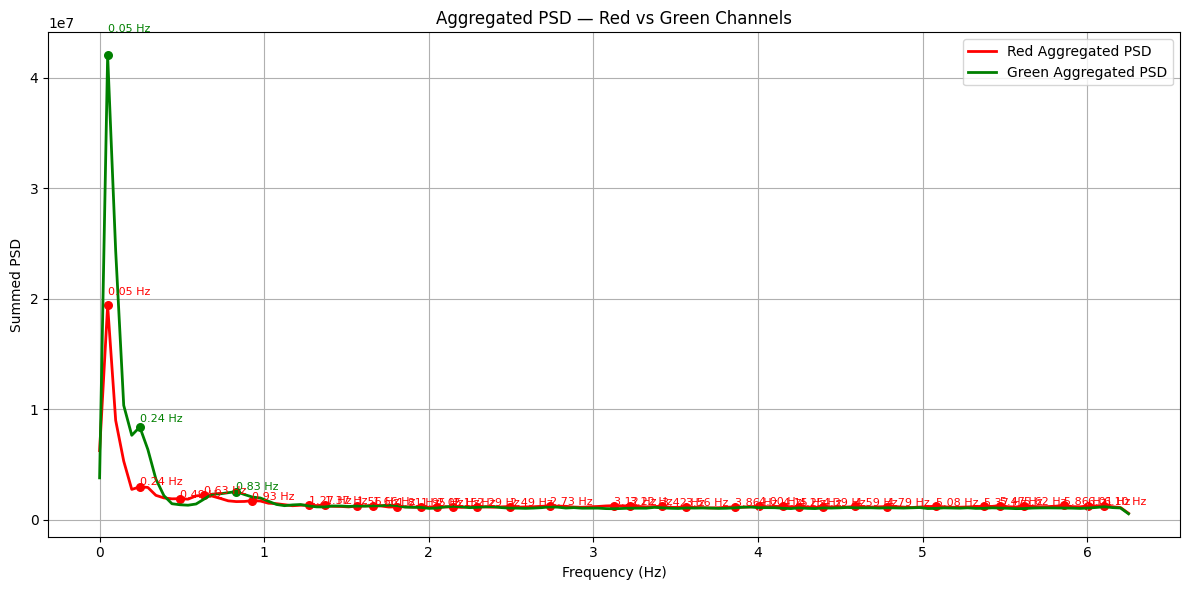

In [134]:
plot_aggregated_psd_by_channel(arr=data_hand_davide_lettura, fs=12.5)

## Hand Green @ Cattedra

In [135]:
data_hand_green = np.load("data_hand_green_20251127_140824.npy")
print("Hand Array shape:", data_hand_green.shape)

Hand Array shape: (350, 65, 65, 2)


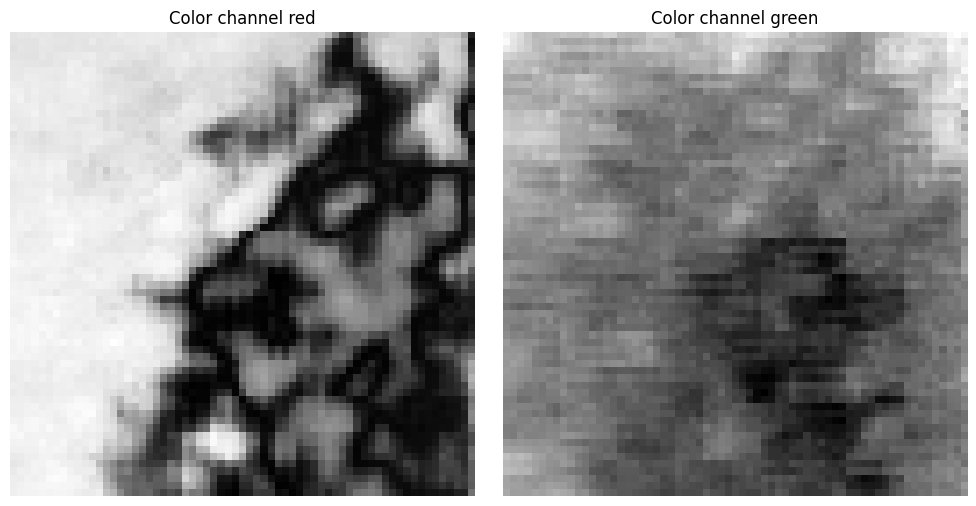

In [136]:
plot_pixel_change_matrix(data=data_hand_green)

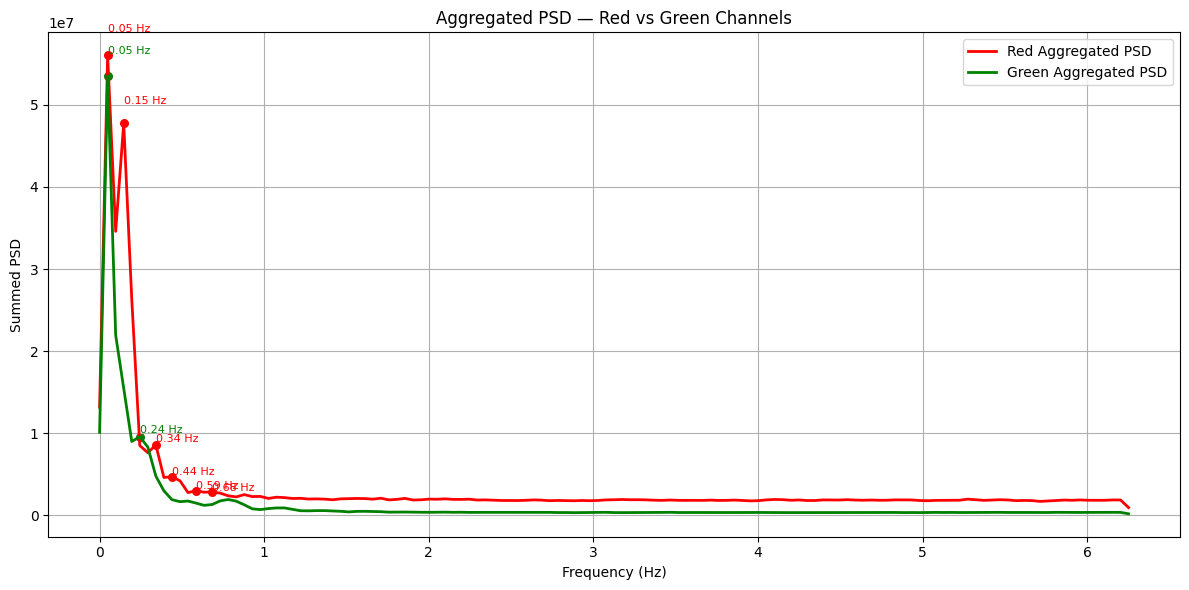

In [137]:
plot_aggregated_psd_by_channel(arr=data_hand_green, fs=12.5)

## Davide Hand @ Cattedra

In [138]:
data_hand_davide_cattedra = np.load("data_hand_davide_class_20251127_140207.npy")
print("Hand Array shape:", data_hand_davide_cattedra.shape)

Hand Array shape: (350, 65, 65, 2)


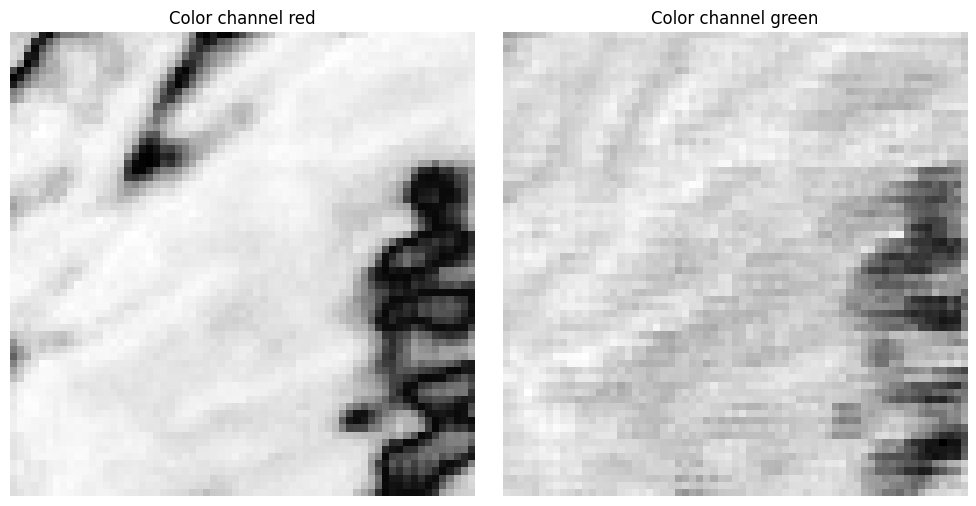

In [139]:
plot_pixel_change_matrix(data=data_hand_davide_cattedra)

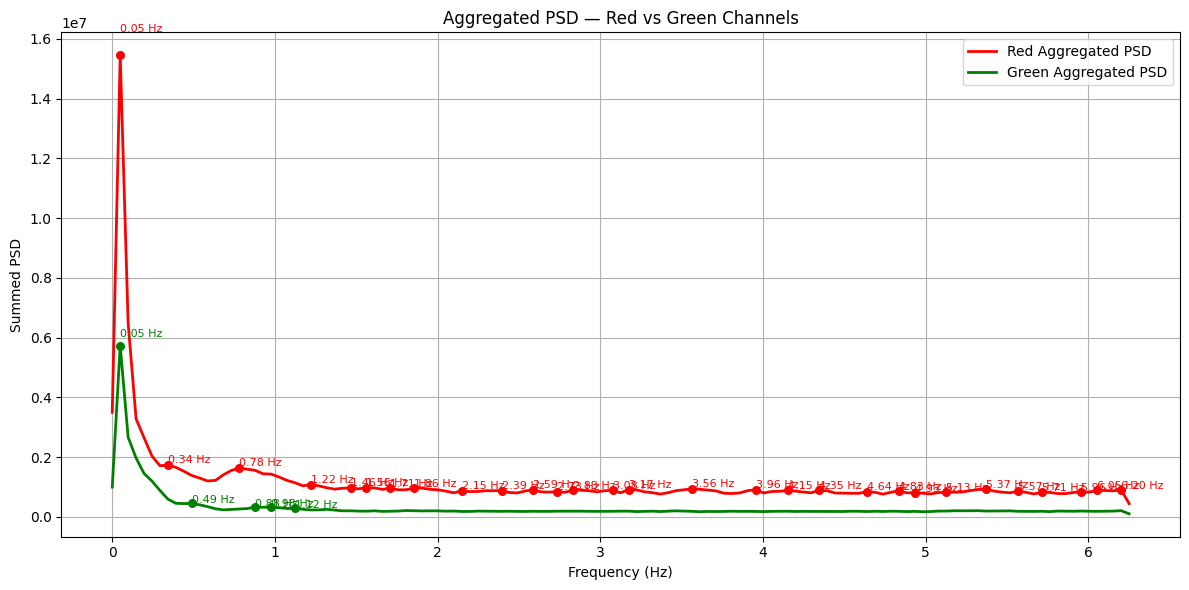

In [140]:
plot_aggregated_psd_by_channel(arr=data_hand_davide_cattedra, fs=12.5)

## Compare three subsequent results

In [141]:
chiara_1 = np.load("data_mano_chiara_1_20251127_143820.npy")
print("Hand Array shape:", chiara_1.shape)
chiara_2 = np.load("data_mano_chiara_2_20251127_144322.npy")
print("Hand Array shape:", chiara_2.shape)
chiara_3 = np.load("data_mano_chiara_3_20251127_144814.npy")
print("Hand Array shape:", chiara_3.shape)

Hand Array shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)
Hand Array shape: (350, 65, 65, 2)


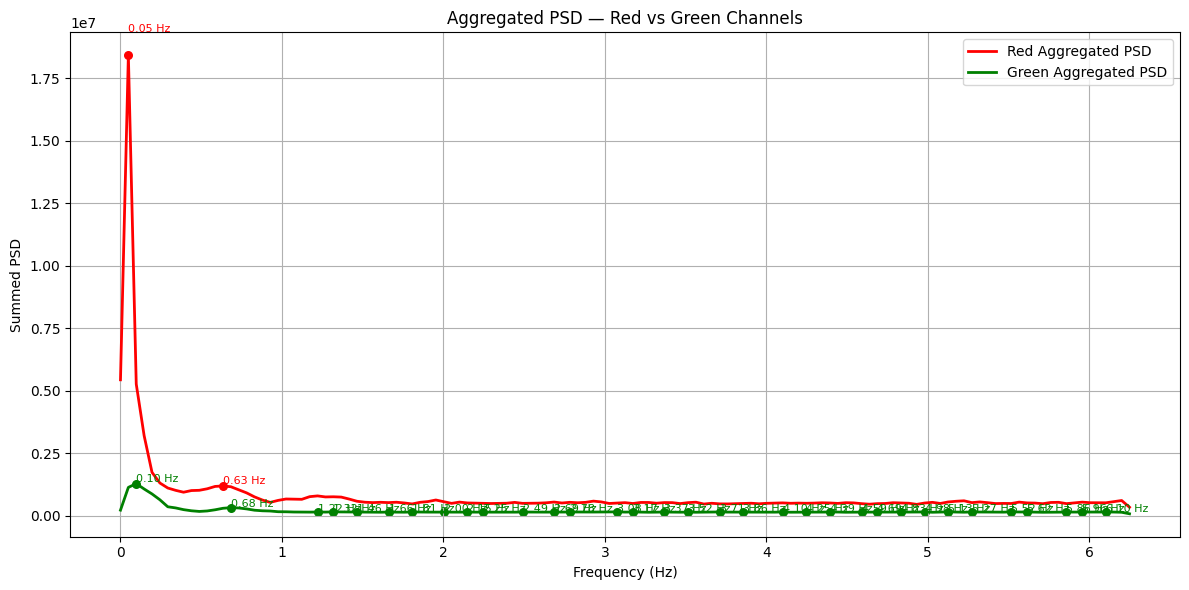

In [142]:
plot_aggregated_psd_by_channel(arr=chiara_1, fs=12.5)

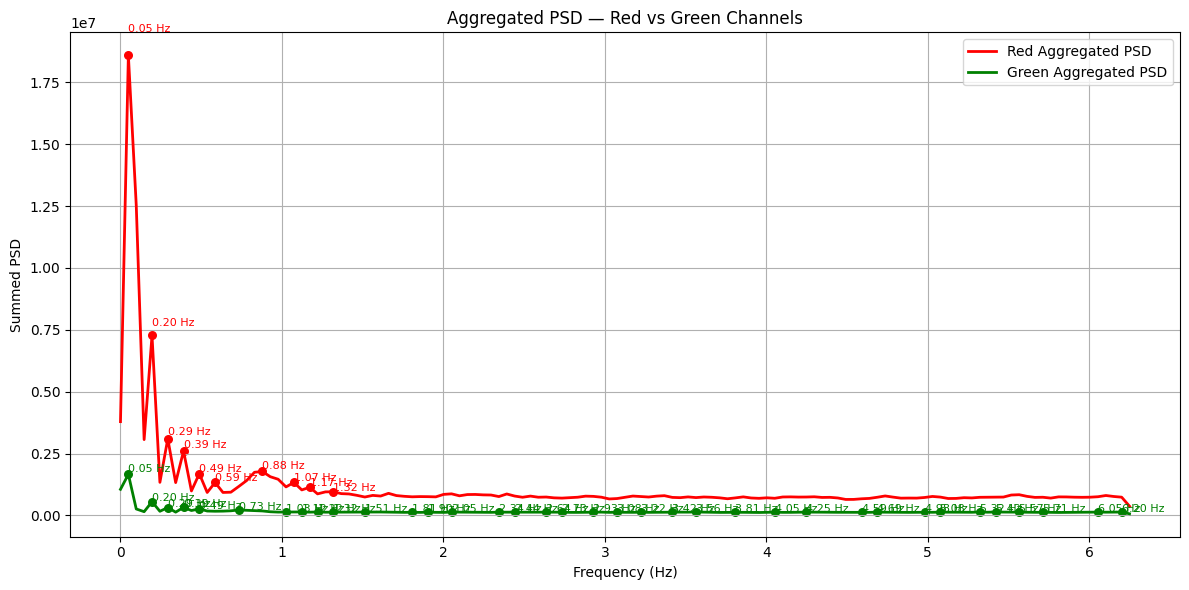

In [143]:
plot_aggregated_psd_by_channel(arr=chiara_2, fs=12.5)

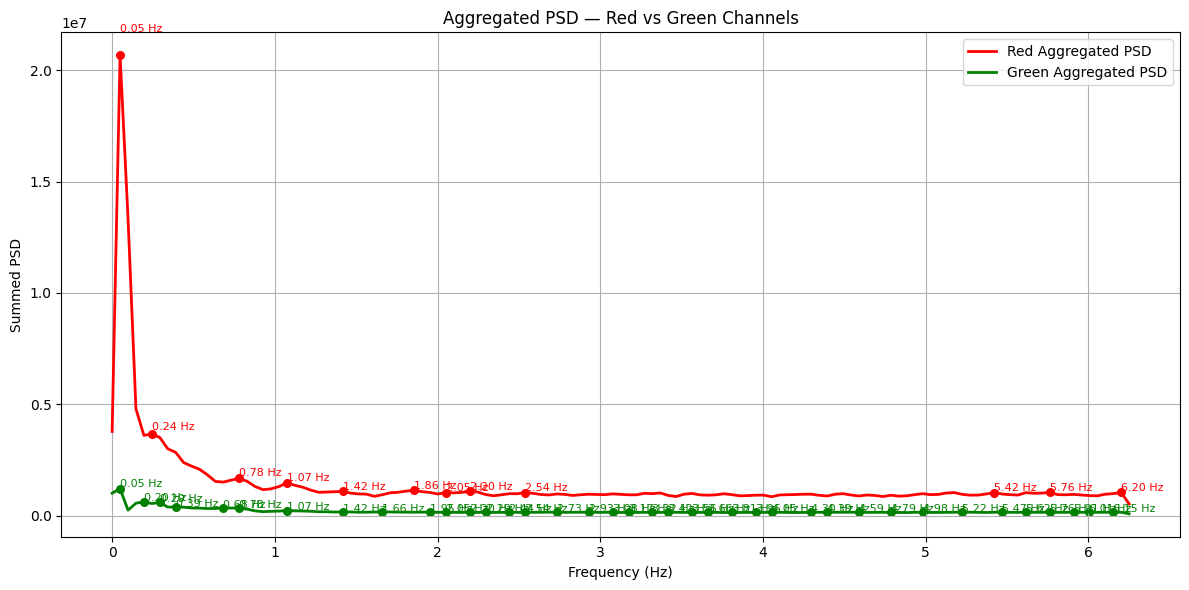

In [144]:
plot_aggregated_psd_by_channel(arr=chiara_3, fs=12.5)